# Hold-out validation

In [1]:
import xgboost
import shap
print(xgboost.__version__, shap.__version__)

0.90 0.34.0


In [2]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cwd = Path.cwd()
datasets = cwd / 'datasets'
results = cwd / 'results/pooled'

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [3]:
raw_df = pd.read_csv(datasets / 'kapusta_grumaz_karius_genus_raw.csv')

# Remove NTCs
raw_df = raw_df.loc[raw_df.y != 'ntc', :]
display(raw_df)

# Binary encode y
raw_df.loc[raw_df.y == 'septic', 'y'] = 1
raw_df.loc[raw_df.y == 'healthy', 'y'] = 0
raw_df = raw_df.astype({'y': 'int'})

# Get hold out set
hold_out = 'karius'
holdout_df = raw_df.loc[raw_df.dataset == hold_out, :]
other_df = raw_df.loc[raw_df.dataset != hold_out, :]

holdout_X = holdout_df.drop(['y', 'dataset'], axis=1).copy()
holdout_y = holdout_df.y.copy()

other_X = other_df.drop(['y', 'dataset'], axis=1).copy()
other_y = other_df.y.copy()

# Relative abundance
other_X_RA = other_X.apply(func=lambda x: x / x.sum(), axis=1)
holdout_X_RA = holdout_X.apply(func=lambda x: x / x.sum(), axis=1)

display(raw_df)
display(holdout_df)
display(other_df)

,dataset,y,Bifidobacterium,Alloscardovia,Arthrobacter,Kocuria,Glutamicibacter,Citricoccus,Micrococcus,Pseudarthrobacter,...,Slackia,Mumia,Thermomonospora,Ilumatobacter,Marinibacterium,Maricaulis,Stella,Eoetvoesia,Bilophila,Paeniclostridium
0,kapusta,healthy,42891.0,1.0,14.0,1.0,3.0,0.0,15.0,1.0,...,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0
1,kapusta,septic,730.0,0.0,48.0,9.0,10.0,1.0,20.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,kapusta,healthy,36074.0,3.0,6.0,56.0,3.0,0.0,21.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,kapusta,healthy,44094.0,0.0,59.0,10.0,21.0,3.0,66.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,kapusta,healthy,26958.0,0.0,6.0,1.0,0.0,0.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,karius,septic,4.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,...,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0
437,karius,septic,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
438,karius,septic,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439,karius,septic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,dataset,y,Bifidobacterium,Alloscardovia,Arthrobacter,Kocuria,Glutamicibacter,Citricoccus,Micrococcus,Pseudarthrobacter,...,Slackia,Mumia,Thermomonospora,Ilumatobacter,Marinibacterium,Maricaulis,Stella,Eoetvoesia,Bilophila,Paeniclostridium
0,kapusta,0,42891.0,1.0,14.0,1.0,3.0,0.0,15.0,1.0,...,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0
1,kapusta,1,730.0,0.0,48.0,9.0,10.0,1.0,20.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,kapusta,0,36074.0,3.0,6.0,56.0,3.0,0.0,21.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,kapusta,0,44094.0,0.0,59.0,10.0,21.0,3.0,66.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,kapusta,0,26958.0,0.0,6.0,1.0,0.0,0.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,karius,1,4.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,...,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0
437,karius,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
438,karius,1,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439,karius,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,dataset,y,Bifidobacterium,Alloscardovia,Arthrobacter,Kocuria,Glutamicibacter,Citricoccus,Micrococcus,Pseudarthrobacter,...,Slackia,Mumia,Thermomonospora,Ilumatobacter,Marinibacterium,Maricaulis,Stella,Eoetvoesia,Bilophila,Paeniclostridium
154,karius,0,1.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,karius,0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156,karius,0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,karius,0,0.0,1.0,6.0,4.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,karius,0,6.0,0.0,4.0,8.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,karius,1,4.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,...,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0
437,karius,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
438,karius,1,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439,karius,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,dataset,y,Bifidobacterium,Alloscardovia,Arthrobacter,Kocuria,Glutamicibacter,Citricoccus,Micrococcus,Pseudarthrobacter,...,Slackia,Mumia,Thermomonospora,Ilumatobacter,Marinibacterium,Maricaulis,Stella,Eoetvoesia,Bilophila,Paeniclostridium
0,kapusta,0,42891.0,1.0,14.0,1.0,3.0,0.0,15.0,1.0,...,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0
1,kapusta,1,730.0,0.0,48.0,9.0,10.0,1.0,20.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,kapusta,0,36074.0,3.0,6.0,56.0,3.0,0.0,21.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,kapusta,0,44094.0,0.0,59.0,10.0,21.0,3.0,66.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,kapusta,0,26958.0,0.0,6.0,1.0,0.0,0.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,grumaz,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,grumaz,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151,grumaz,1,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152,grumaz,1,23.0,0.0,0.0,9.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute train test split size

In [4]:
n_splits = 10

pos = len(other_y[other_y == 1])
neg = len(other_y[other_y == 0])
test_pos = len(holdout_y[holdout_y == 1])
test_neg = len(holdout_y[holdout_y == 0])
split_sizes = pd.DataFrame({'Septic': [pos - int(pos / n_splits), int(pos / n_splits), test_pos], 
                           'Healthy': [neg - int(neg / n_splits), int(neg / n_splits), test_neg]}, 
                           index=['Train fold', 'Validation fold', 'Test fold'])

## Nested CV for hyperparameter optimisation

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

In [6]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(100, 300, 10)
    max_depth = range(1, 5, 1)
    gamma = np.linspace(0.1, 3, 10)
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = np.linspace(0.1, 1, 20)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
    model = RandomizedSearchCV(model, 
                               param_grid, 
                               scoring='roc_auc',
                               n_iter=1000,
                               n_jobs=70, 
                               cv=inner_cv, 
                               verbose=0)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'AUPRC': auprc,
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC', 'test_AUPRC']]

    return outer_results, best_params


## Analysis

### 1. Optimise and evaluate clean models trained on Grumaz + Kapusta

In [7]:
raw_results, raw_params = optimise_evaluate(other_X, other_y)
# raw_params = {'subsample': 0.5263157894736842, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 96, 'max_depth': 2, 'gamma': 1.8421052631578947, 'colsample_bytree': 0.19473684210526315}

RA_results, RA_params = optimise_evaluate(other_X_RA, other_y)
# RA_params = {'subsample': 0.4789473684210527, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 255, 'max_depth': 1, 'gamma': 0.7894736842105263, 'colsample_bytree': 0.4}


{'subsample': 0.7, 'scale_pos_weight': 0.336283185840708, 'n_estimators': 200, 'max_depth': 3, 'gamma': 0.42222222222222217, 'colsample_bytree': 0.1}
{'subsample': 0.7, 'scale_pos_weight': 0.336283185840708, 'n_estimators': 270, 'max_depth': 4, 'gamma': 2.033333333333333, 'colsample_bytree': 0.1473684210526316}


### 2. Decontamination

#### Fit dirty model

In [8]:
raw_model = XGBClassifier(**raw_params)
raw_model.fit(other_X, other_y)

XGBClassifier(colsample_bytree=0.1, gamma=0.42222222222222217, n_estimators=200,
              scale_pos_weight=0.336283185840708, subsample=0.7)

#### Remove non-human associated pathogens

In [9]:
# Retrieve known human pathogens
meta = pd.read_csv(datasets / 'pathogen_list.csv', encoding= 'unicode_escape')
meta = meta['Genus'].unique()

# Remove non-human pathogens
genera_new = other_X.columns
genera_new = list(set(genera_new).intersection(set(meta)))

#### Remove contaminants based on SHAP values

In [10]:
import math
from scipy.stats import spearmanr
import shap


def decontam(X_train, y_train, params):
    X_train = X_train.copy()
    y_train = y_train.copy()
    params = params.copy()
    
    model = XGBClassifier(**params)
    model.fit(X=X_train, y=y_train)

    explainer = shap.TreeExplainer(model, feature_pertubation='interventional', model_output='probability', data=X_train)
    shap_val = explainer.shap_values(X_train)

    to_retain = np.array([True] * X_train.shape[1])
    corrs = np.zeros(X_train.shape[1])
    
    for i in range(X_train.shape[1]):
        if sum(X_train.iloc[:, i] != 0) >= X_train.shape[0] * 0.1:
            rho = spearmanr(X_train.iloc[:, i], shap_val[:, i])[0]
            p = spearmanr(X_train.iloc[:, i], shap_val[:, i])[1]
            print(f'rho={rho}, p={p}, genus={X_train.columns[i]}')
            
            if rho < 0:
                to_retain[i] = False
                
            elif not shap_val[:, i].any(0):
                to_retain[i] = False
        else:
            to_retain[i] = False

    to_retain = X_train.columns[to_retain]
    print(to_retain.shape, to_retain)
    
    return to_retain

In [11]:
# Decontam using raw_params
for _ in range(10):
    genera_new = decontam(other_X.loc[:, genera_new], other_y, raw_params)

rho=-0.277021855972936, p=0.0005743255898167671, genus=Bifidobacterium
rho=0.7110258291812392, p=1.4844824830087602e-24, genus=Delftia
rho=-0.7770133926838283, p=9.355095088070242e-32, genus=Staphylococcus
rho=nan, p=nan, genus=Leifsonia
rho=nan, p=nan, genus=Psychrobacter
rho=-0.7592988916065453, p=1.349080202138056e-29, genus=Lactococcus
rho=nan, p=nan, genus=Halomonas
rho=nan, p=nan, genus=Shewanella
rho=nan, p=nan, genus=Moraxella
rho=nan, p=nan, genus=Porphyromonas
rho=0.4003672246867435, p=3.513086119741646e-07, genus=Sphingomonas
rho=-0.296865323868207, p=0.00021439027361914886, genus=Flavobacterium
rho=-0.16961219384971984, p=0.03734064789915684, genus=Afipia
rho=nan, p=nan, genus=Carnobacterium
rho=0.7896816336966194, p=2.002599117065124e-33, genus=Stenotrophomonas
rho=-0.7481746876432195, p=2.470899814279914e-28, genus=Lachnoclostridium
rho=-0.5982592238090015, p=4.993448113056925e-16, genus=Mycoplasma
rho=nan, p=nan, genus=Gemella
rho=-0.6377207028099147, p=1.304659577834014

An input array is constant; the correlation coefficent is not defined.


rho=0.1219073249338576, p=0.13592439262414596, genus=Delftia
rho=0.002601592732436892, p=0.9747086612523781, genus=Sphingomonas
rho=0.7600535738997743, p=1.1012573409801312e-29, genus=Stenotrophomonas
rho=-0.7352155238016681, p=6.0689660159077266e-27, genus=Bacillus
rho=0.7507942532481674, p=1.263250216934176e-28, genus=Rhodococcus
rho=0.7538201578335659, p=5.759553820064766e-29, genus=Dermabacter
rho=0.6864803072911557, p=2.2732885930698107e-22, genus=Morganella
rho=-0.3048055867558833, p=0.0001416054543844417, genus=Microbacterium
rho=-0.6481319103723334, p=2.345701998043673e-19, genus=Bosea
rho=0.173474418671955, p=0.03315897050312701, genus=Bartonella
rho=0.7024624809002671, p=9.103898925910515e-24, genus=Comamonas
rho=0.6781525404564123, p=1.1216275477470191e-21, genus=Pseudoclavibacter
rho=0.6982343237363573, p=2.1770546274956248e-23, genus=Cellulosimicrobium
rho=-0.5142230765832161, p=1.4437509416635619e-11, genus=Rothia
rho=0.5824140713379595, p=4.353792138589947e-15, genus=Ser

rho=0.6816394068743169, p=5.78624915635271e-22, genus=Stenotrophomonas
rho=0.6999415405458863, p=1.5338429614803963e-23, genus=Rhodococcus
rho=0.7613764094445883, p=7.701781555037432e-30, genus=Dermabacter
rho=0.6882742020109265, p=1.6006239169010812e-22, genus=Morganella
rho=0.6218839515316383, p=1.5703793923412405e-17, genus=Cellulosimicrobium
rho=0.755037075878052, p=4.186129688798015e-29, genus=Oerskovia
rho=0.7235701464283291, p=9.217095166991496e-26, genus=Citrobacter
rho=0.38792837222708243, p=8.590575659663717e-07, genus=Curtobacterium
(8,) Index(['Stenotrophomonas', 'Rhodococcus', 'Dermabacter', 'Morganella',
       'Cellulosimicrobium', 'Oerskovia', 'Citrobacter', 'Curtobacterium'],
      dtype='object')
rho=0.6816394068743169, p=5.78624915635271e-22, genus=Stenotrophomonas
rho=0.6999415405458863, p=1.5338429614803963e-23, genus=Rhodococcus
rho=0.7613764094445883, p=7.701781555037432e-30, genus=Dermabacter
rho=0.6882742020109265, p=1.6006239169010812e-22, genus=Morganella
rho

In [12]:
# Decontam + pathogens
other_X_raw_CR = other_X[genera_new]

# Normalise RA
other_X_RA_CR = other_X_raw_CR.apply(func=lambda x: x / x.sum(), axis=1)

#### Number of features before and after decontamination

In [13]:
print('Neat', other_X.shape)
print('CR', other_X_raw_CR.shape)

Neat (151, 685)
CR (151, 8)


### 3. Optimise and evaluate decontaminated models

In [14]:
raw_CR_results, raw_CR_params = optimise_evaluate(other_X_raw_CR, other_y)

RA_CR_results, RA_CR_params = optimise_evaluate(other_X_RA_CR, other_y)

{'subsample': 0.6, 'scale_pos_weight': 0.336283185840708, 'n_estimators': 120, 'max_depth': 2, 'gamma': 1.3888888888888888, 'colsample_bytree': 0.38421052631578945}
{'subsample': 0.6, 'scale_pos_weight': 0.336283185840708, 'n_estimators': 190, 'max_depth': 3, 'gamma': 0.42222222222222217, 'colsample_bytree': 0.9526315789473684}


## Estimate test error (hold-out)

In [15]:
def estimate_error(param_dict, x_train, y_train, x_test, y_test):
    model = XGBClassifier(**param_dict)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_score = model.predict_proba(x_test)[:, 1]
    
    precision = precision_score(y_true=y_test, y_pred=y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    F1 = f1_score(y_true=y_test, y_pred=y_pred)
    auroc = roc_auc_score(y_true=y_test, y_score=y_score)
    auprc = average_precision_score(y_true=y_test, y_score=y_score)
    
    return model, pd.Series({'external_test_precision': precision,
                             'external_test_recall': recall,
                             'external_test_F1': F1,
                             'external_test_AUROC': auroc,
                             'external_test_AUPRC': auprc})

### Train on Grumaz + Kapusta, test on holdout

#### Preprocess test dataset

In [16]:
holdout_X_raw_CR = holdout_X.loc[:, other_X_raw_CR.columns]
holdout_X_RA_CR = holdout_X_raw_CR.apply(func=lambda x: x / x.sum(), axis=1)

#### Before decontamination

In [17]:
_, external_error_raw = estimate_error(raw_params, other_X, other_y, holdout_X, holdout_y)
_, external_error_RA = estimate_error(RA_params, other_X_RA, other_y, holdout_X_RA, holdout_y)

#### After decontamination

In [18]:
raw_CR_model, external_error_raw_CR = estimate_error(raw_CR_params, other_X_raw_CR, other_y, holdout_X_raw_CR, holdout_y)
_, external_error_RA_CR = estimate_error(RA_CR_params, other_X_RA_CR, other_y, holdout_X_RA_CR, holdout_y)

In [19]:
#### Combine all results
metric_df = pd.DataFrame({'Raw': raw_results, 'RA': RA_results, 
                          'Raw CR': raw_CR_results, 'RA CR': RA_CR_results}).round(3).T

ext_metric_df = pd.DataFrame({'Raw': external_error_raw, 'RA': external_error_RA, 
                              'Raw CR': external_error_raw_CR, 'RA CR': external_error_RA_CR}).round(3).T

final_results = pd.concat([metric_df, ext_metric_df], axis=1)

#### SHAP summary plots for dirty and decontaminated models

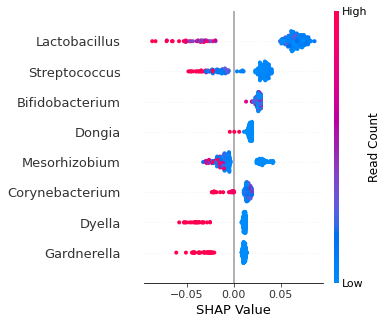

In [23]:
import matplotlib.pyplot as plt

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=other_X)
shap_raw = explainer_raw.shap_values(holdout_X)

explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=other_X_raw_CR)
shap_CR = explainer_CR.shap_values(holdout_X_raw_CR)

shap.summary_plot(shap_raw, holdout_X, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=other_X_raw_CR.shape[1])
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / f'hold_{hold_out}_out_raw_shap.png', dpi=600, format='png', bbox_inches='tight')

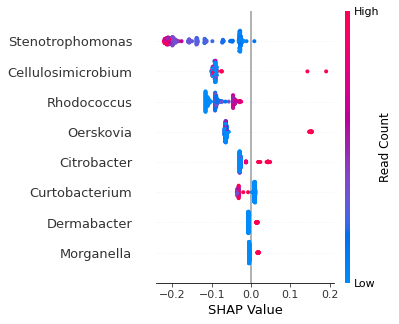

In [24]:
shap.summary_plot(shap_CR, holdout_X_raw_CR, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=other_X_raw_CR.shape[1])
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / f'hold_{hold_out}_raw_CR_shap.png', dpi=600, format='png', bbox_inches='tight')

### Final Results

In [25]:
display(split_sizes)
display(final_results)
final_results.to_csv(results / f'hold_{hold_out}_out_model_results.csv', index=True, header=True)

,Septic,Healthy
Train fold,102,35
Validation fold,11,3
Test fold,117,170


,test_precision,test_recall,test_F1,test_AUROC,test_AUPRC,external_test_precision,external_test_recall,external_test_F1,external_test_AUROC,external_test_AUPRC
Raw,0.982,0.948,0.963,0.988,0.970,0.404,0.957,0.569,0.501,0.431
RA,0.974,0.964,0.968,0.995,0.967,0.416,0.932,0.575,0.636,0.528
Raw CR,0.970,0.859,0.909,0.930,0.941,1.000,0.026,0.050,0.457,0.420
RA CR,0.917,0.876,0.889,0.883,0.894,0.441,0.419,0.430,0.535,0.504
